In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install Python packages
!pip install pytorch-ignite efficientnet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 5.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=089855f7c860e6d51fe25b95a8feb7a5daf6972c7355ab99909bc6a306c827dc
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from datetime import datetime as dt
import time

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets
from efficientnet_pytorch import EfficientNet
import torch.nn.functional as F
import argparse

import os
from random import randint
from sklearn import metrics
import urllib
import zipfile
import csv

import math
from torch.utils.data import Subset
from torch.utils.data import random_split

In [ ]:
parser = argparse.ArgumentParser(description='Process some integers.')

parser.add_argument('-gpu', default=-1, type=int, help='The index of the gpu used')
parser.add_argument('-num_comp', default=1, type=int,
                    help='The number of composite elements')
parser.add_argument('-save_dir', default='.', type=str, help='set save directory')
parser.add_argument('-seed', default=123, type=int, help='set random seed')

args = parser.parse_args("")
print(args)

Namespace(gpu=-1, num_comp=1, save_dir='.', seed=123)


In [ ]:
num_comp = args.num_comp
save_dir = args.save_dir
model_save_dir = os.path.join(save_dir, "models")
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

if args.seed is not None:
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

In [ ]:
!ls

drive  models  sample_data


# **Get the hierarchy**

In [ ]:
# # Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
  
# # Unzip raw zip file
!unzip -qq 'tiny-imagenet-200.zip'

# Define main data directory
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

--2022-09-06 20:40:00--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  52.3MB/s    in 6.4s    

2022-09-06 20:40:06 (36.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
TRAIN_DIR

'tiny-imagenet-200/train'

In [ ]:
!ls

drive  models  sample_data  tiny-imagenet-200  tiny-imagenet-200.zip


In [ ]:
tinyImageNet_class_wnids = set()
for subclass in os.listdir(TRAIN_DIR):
    tinyImageNet_class_wnids.add(subclass)


In [ ]:
tinyImageNet_class_wnids

{'n01443537',
 'n01629819',
 'n01641577',
 'n01644900',
 'n01698640',
 'n01742172',
 'n01768244',
 'n01770393',
 'n01774384',
 'n01774750',
 'n01784675',
 'n01855672',
 'n01882714',
 'n01910747',
 'n01917289',
 'n01944390',
 'n01945685',
 'n01950731',
 'n01983481',
 'n01984695',
 'n02002724',
 'n02056570',
 'n02058221',
 'n02074367',
 'n02085620',
 'n02094433',
 'n02099601',
 'n02099712',
 'n02106662',
 'n02113799',
 'n02123045',
 'n02123394',
 'n02124075',
 'n02125311',
 'n02129165',
 'n02132136',
 'n02165456',
 'n02190166',
 'n02206856',
 'n02226429',
 'n02231487',
 'n02233338',
 'n02236044',
 'n02268443',
 'n02279972',
 'n02281406',
 'n02321529',
 'n02364673',
 'n02395406',
 'n02403003',
 'n02410509',
 'n02415577',
 'n02423022',
 'n02437312',
 'n02480495',
 'n02481823',
 'n02486410',
 'n02504458',
 'n02509815',
 'n02666196',
 'n02669723',
 'n02699494',
 'n02730930',
 'n02769748',
 'n02788148',
 'n02791270',
 'n02793495',
 'n02795169',
 'n02802426',
 'n02808440',
 'n02814533',
 'n028

In [ ]:
K = len(tinyImageNet_class_wnids)
print('number of singleton classes: ',K)

number of singleton classes:  200


In [ ]:
def have_dummy(row):
    s = row[0]+row[1]
    return ('dummy' in s)

def remove_dummy(tab):
    new_tab = []
    for row in tab:
        if have_dummy(row)==False:
            new_tab.append(row)
    return new_tab

imagenet_hierarchy_path = "drive/MyDrive/Projects/HyperEvidentialNN/TinyImageNet/"
with open(imagenet_hierarchy_path+'ImageNetHierarchy.txt') as f:
    reader = csv.reader(f, delimiter=' ')
    hierarchy = [line for line in reader]
##### hierarchy:size 1327*2 each row contains the information [superclass, subclass]
hierarchy = remove_dummy(hierarchy)

In [ ]:
print(type(hierarchy), len(hierarchy))

<class 'list'> 1224


In [ ]:
parent_to_subclass = {}
for superclass, subclass in hierarchy:
    if subclass in tinyImageNet_class_wnids:
        if superclass not in parent_to_subclass.keys():
            parent_to_subclass[superclass] = [subclass]
        else:
            parent_to_subclass[superclass].append(subclass)

print("length of parent_to_subclass: ", len(parent_to_subclass))
for superClass in parent_to_subclass:
    print(superClass, ': ', parent_to_subclass[superClass])

length of parent_to_subclass:  107
n04230808 :  ['n03770439']
n04370048 :  ['n02963159']
n04371563 :  ['n02837789', 'n04371430']
n03419014 :  ['n02730930', 'n03763968']
n03057021 :  ['n03404251', 'n02669723', 'n04532106', 'n03980874', 'n03617480']
n03314378 :  ['n03424325']
n04272054 :  ['n04356056']
n03815615 :  ['n02883205']
n02887209 :  ['n03814639']
n03381126 :  ['n04254777']
n04323819 :  ['n03026506']
n04199027 :  ['n04133789']
n03497657 :  ['n04259630']
n02773037 :  ['n02769748']
n02958343 :  ['n02814533', 'n03100240', 'n03670208', 'n04285008', 'n03444034', 'n03977966']
n04490091 :  ['n04465501', 'n03796401']
n02924116 :  ['n04146614', 'n04487081']
n03896233 :  ['n02917067']
n02959942 :  ['n03393912']
n02970849 :  ['n03599486']
n02858304 :  ['n03447447', 'n03662601']
n04379243 :  ['n03179701', 'n03201208']
n03001627 :  ['n04099969']
n03636649 :  ['n03637318']
n07681926 :  ['n07695742']
n07557434 :  ['n07871810', 'n07873807', 'n07875152']
n07710616 :  ['n07711569']
n07611358 :  ['

In [ ]:
word_mapping = DATA_DIR + '/' + 'words.txt'
with open(word_mapping) as f:
    tab_raw = f.readlines()
ID_to_names = {}
for row in tab_raw:
    row = row.replace('\n','').split('\t')
    WNID = row[0]
    ImageLabels = row[1].split(', ')
    if WNID in tinyImageNet_class_wnids or WNID in parent_to_subclass:
        ID_to_names[WNID] = ImageLabels

In [ ]:
print('number of WNIDs: ', len(ID_to_names.keys()))

number of WNIDs:  307


In [ ]:
for superClass in ID_to_names:
    print(superClass, ': ', ID_to_names[superClass])

n01443537 :  ['goldfish', 'Carassius auratus']
n01629276 :  ['salamander']
n01629819 :  ['European fire salamander', 'Salamandra salamandra']
n01639765 :  ['frog', 'toad', 'toad frog', 'anuran', 'batrachian', 'salientian']
n01640846 :  ['true frog', 'ranid']
n01641577 :  ['bullfrog', 'Rana catesbeiana']
n01644900 :  ['tailed frog', 'bell toad', 'ribbed toad', 'tailed toad', 'Ascaphus trui']
n01698434 :  ['alligator', 'gator']
n01698640 :  ['American alligator', 'Alligator mississipiensis']
n01726692 :  ['snake', 'serpent', 'ophidian']
n01742172 :  ['boa constrictor', 'Constrictor constrictor']
n01767661 :  ['arthropod']
n01768244 :  ['trilobite']
n01769347 :  ['arachnid', 'arachnoid']
n01770393 :  ['scorpion']
n01772222 :  ['spider']
n01774384 :  ['black widow', 'Latrodectus mactans']
n01774750 :  ['tarantula']
n01784675 :  ['centipede']
n01844917 :  ['aquatic bird']
n01855672 :  ['goose']
n01881171 :  ['phalanger', 'opossum', 'possum']
n01882714 :  ['koala', 'koala bear', 'kangaroo be

In [ ]:
for superClass in parent_to_subclass:
  print(ID_to_names[superClass], ": ", end="")
  for subclass in parent_to_subclass[superClass]:
    print(ID_to_names[subclass], end="")
  print("")

['skirt'] : ['miniskirt', 'mini']
['sweater', 'jumper'] : ['cardigan']
['swimsuit', 'swimwear', 'bathing suit', 'swimming costume', 'bathing costume'] : ['bikini', 'two-piece']['swimming trunks', 'bathing trunks']
['garment'] : ['apron']['military uniform']
['coat'] : ['fur coat']['academic gown', 'academic robe', "judge's robe"]['vestment']['poncho']['kimono']
['face mask'] : ['gasmask', 'respirator', 'gas helmet']
['spectacles', 'specs', 'eyeglasses', 'glasses'] : ['sunglasses', 'dark glasses', 'shades']
['necktie', 'tie'] : ['bow tie', 'bow-tie', 'bowtie']
['brace'] : ['neck brace']
['footwear'] : ['sock']
['stocking'] : ['Christmas stocking']
['shoe'] : ['sandal']
['hat', 'chapeau', 'lid'] : ['sombrero']
['bag'] : ['backpack', 'back pack', 'knapsack', 'packsack', 'rucksack', 'haversack']
['car', 'auto', 'automobile', 'machine', 'motorcar'] : ['beach wagon', 'station wagon', 'wagon', 'estate car', 'beach waggon', 'station waggon', 'waggon']['convertible']['limousine', 'limo']['sport

In [ ]:
for superClass in parent_to_subclass:
  if superClass in tinyImageNet_class_wnids:
    print("Leaf node")

In [ ]:
count = 0
superclasses_multiple = []
for superClass in parent_to_subclass:
    if len(parent_to_subclass[superClass]) == 2 or len(parent_to_subclass[superClass]) == 3:
        superclasses_multiple.append(superClass)
        count += 1
        print(ID_to_names[superClass], ": ", end="")
        for subclass in parent_to_subclass[superClass]:
            print(ID_to_names[subclass], end="")
        print(", Num of subclasses: ", len(parent_to_subclass[superClass]))
print('number of candidate superclasses (for making vague samples): ', count)

['swimsuit', 'swimwear', 'bathing suit', 'swimming costume', 'bathing costume'] : ['bikini', 'two-piece']['swimming trunks', 'bathing trunks'], Num of subclasses:  2
['garment'] : ['apron']['military uniform'], Num of subclasses:  2
['truck', 'motortruck'] : ['tractor']['moving van'], Num of subclasses:  2
['bus', 'autobus', 'coach', 'charabanc', 'double-decker', 'jitney', 'motorbus', 'motorcoach', 'omnibus', 'passenger vehicle'] : ['school bus']['trolleybus', 'trolley coach', 'trackless trolley'], Num of subclasses:  2
['boat'] : ['gondola']['lifeboat'], Num of subclasses:  2
['table'] : ['desk']['dining table', 'board'], Num of subclasses:  2
['dish'] : ['meat loaf', 'meatloaf']['pizza', 'pizza pie']['potpie'], Num of subclasses:  3
['frozen dessert'] : ['ice cream', 'icecream']['ice lolly', 'lolly', 'lollipop', 'popsicle'], Num of subclasses:  2
['vegetable', 'veggie', 'veg'] : ['mushroom']['cauliflower'], Num of subclasses:  2
['mercantile establishment', 'retail store', 'sales out

In [ ]:
subclasses = []
for superclass in parent_to_subclass:
    subclasses += parent_to_subclass[superclass]
### check if there is a subclasses with more than one superclass
print(len(subclasses))
print(len(set(subclasses)))

175
175


# **Data Preprocessing**

In [ ]:
val_img_dir = os.path.join(VALID_DIR, 'images')
fp = open(os.path.join(VALID_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

val_img_dict = {}
for line in data:
    words = line.split('\t')
    val_img_dict[words[0]] = words[1]
fp.close()

{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [ ]:
# Create subfolders (if not present) for validation images based on label,
# and move images into the respective folders
for img, folder in val_img_dict.items():
    newpath = (os.path.join(val_img_dir, folder))
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    if os.path.exists(os.path.join(val_img_dir, img)):
        os.rename(os.path.join(val_img_dir, img), os.path.join(newpath, img))

In [ ]:
preprocess_transform_pretrain = T.Compose([
                T.Resize(256), # Resize images to 256 x 256
                T.CenterCrop(224), # Center crop image
                T.RandomHorizontalFlip()
])

In [ ]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=preprocess_transform_pretrain)
test_ds = datasets.ImageFolder(val_img_dir, transform=preprocess_transform_pretrain)

In [ ]:
classes_to_idx = train_ds.class_to_idx
idx_to_class = {value:key for key, value in classes_to_idx.items()}
K = len(classes_to_idx)
# print("Num of Singleton Classes: {}".format(K))
print(len(classes_to_idx), classes_to_idx)

200 {'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9, 'n01784675': 10, 'n01855672': 11, 'n01882714': 12, 'n01910747': 13, 'n01917289': 14, 'n01944390': 15, 'n01945685': 16, 'n01950731': 17, 'n01983481': 18, 'n01984695': 19, 'n02002724': 20, 'n02056570': 21, 'n02058221': 22, 'n02074367': 23, 'n02085620': 24, 'n02094433': 25, 'n02099601': 26, 'n02099712': 27, 'n02106662': 28, 'n02113799': 29, 'n02123045': 30, 'n02123394': 31, 'n02124075': 32, 'n02125311': 33, 'n02129165': 34, 'n02132136': 35, 'n02165456': 36, 'n02190166': 37, 'n02206856': 38, 'n02226429': 39, 'n02231487': 40, 'n02233338': 41, 'n02236044': 42, 'n02268443': 43, 'n02279972': 44, 'n02281406': 45, 'n02321529': 46, 'n02364673': 47, 'n02395406': 48, 'n02403003': 49, 'n02410509': 50, 'n02415577': 51, 'n02423022': 52, 'n02437312': 53, 'n02480495': 54, 'n02481823': 55, 'n02486410': 56, 'n02504458': 57, 'n02509815': 58, 'n

In [ ]:
# num_comp = 1
print(f'randomly selecting %d vague classes from %d candidate superclasses:'%(num_comp, count))
vague_classes = random.sample(superclasses_multiple, num_comp)
print(vague_classes)

randomly selecting 1 vague classes from 29 candidate superclasses:
['n02121808']


In [ ]:
# vague_classes = ['n02121808']

In [ ]:
C = [[classes_to_idx[sub_class] for sub_class in parent_to_subclass[super_class]] for super_class in vague_classes]
kappa = K + len(C)
print('Composite set interget labels:')
print(C)

Composite set interget labels:
[[30, 31, 32]]


In [ ]:
for i in range(len(C)):
    idx_to_class[K + i] = [idx_to_class[k] for k in C[i]]
print('Interger class label to WNIDs:')
print(idx_to_class)

Interger class label to WNIDs:
{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695', 20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799', 30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429', 40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003', 50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 57: 'n025

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, subset, class_num=None, transform=None):
        self.subset = subset
        self.transform = transform
        self.class_num = class_num
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        if self.class_num is not None:
          return x, self.class_num
        else:
          return x, y
        
    def __len__(self):
        return len(self.subset)

In [ ]:
for vague_class in range(K, kappa):
    print("Vague class:", vague_class, ", Num of Subclasses:", len(parent_to_subclass[vague_classes[vague_class-K]]))

Vague class: 200 , Num of Subclasses: 3


In [ ]:
def get_sample_idx_by_class(dataset, num_classes):
    sample_idx_by_class = [[] for i in range(num_classes)]
    for i in range(len(dataset)):
        sample_idx_by_class[dataset[i][1]].append(i)
    return sample_idx_by_class

def make_valid_ds(dataset, perc=0):
    valid_list = []
    train_list = []
    valid_class_indices = []
    train_class_indices = []
    sample_idx_by_class = get_sample_idx_by_class(dataset, kappa)
    for samples in sample_idx_by_class:
        valid_samples = random.sample(samples, int(len(samples)*perc))
        valid_class_indices.append(valid_samples)
        train_class_indices.append(list(set(samples)-set(valid_samples)))
    valid_ds = Subset(dataset, valid_class_indices[0])
    train_ds = Subset(dataset, train_class_indices[0])
    for k in range(1, kappa):
        valid_ds += Subset(dataset, valid_class_indices[k])
        train_ds += Subset(dataset, train_class_indices[k])
    return train_ds, valid_ds
    

def make_vague_samples(dataset, guass_blur_sigma = 15):
    num_samples_subclass = len([i for i in range(len(dataset)) if dataset[i][1] == 0])  
    for k in range(K, kappa):
        num_vague_samples_subclass = math.floor(num_samples_subclass / (len(idx_to_class[k]) + 1.0))
        num_nonvague_samples_subclass = num_samples_subclass - num_vague_samples_subclass
        sample_indices = [i for i in range(len(dataset))]
        for subclass in C[k - K]:
            idx_candidates = [i for i in range(len(dataset)) if dataset[i][1] == subclass]
            ### idx_candidates = [i for i in sample_indices_by_class[subclass] if dataset[i][1]==subclass]
            idx_non_candidates = list(set(sample_indices)-set(idx_candidates))
            subset1 = Subset(dataset, idx_non_candidates)
            subset2 = Subset(dataset, idx_candidates)

            nonvague_samples, vague_samples = random_split(subset2, [num_nonvague_samples_subclass, num_vague_samples_subclass])
            vague_samples = CustomDataset(subset=vague_samples, class_num=k, transform=T.GaussianBlur(kernel_size=(35, 45), sigma = guass_blur_sigma))
                                                            
            dataset = subset1 + nonvague_samples + vague_samples
            ### can we avoid changing the order of samples in dataset?
    return dataset


In [ ]:
print('making vague samples for whole dataset ...')
start = time.time()
train_ds = make_vague_samples(train_ds)
test_ds = make_vague_samples(test_ds)
end = time.time()
print(f'Total processing time: %s seconds'%str(end-start))

making vague samples for whole dataset ...
Total processing time: 485.86382246017456 seconds


In [ ]:
print("Training set Size:", len(train_ds), '(unsplitted)')
print("Testing set Size:", len(test_ds))

Training set Size: 100000 (unsplitted)
Testing set Size: 10000


In [ ]:
def printImage(image, label):
  plt.imshow(image)
  if label < K:
   print('Label: {} ({})'.format(ID_to_names[idx_to_class[label]], label))
  else:
    subclass_names = []
    for subclass in idx_to_class[label]:
      subclass_names.append(ID_to_names[subclass])
    print('Label: {} ({})'.format(subclass_names, label))

In [ ]:
indexes = [i for i in range(len(train_ds)) if train_ds[i][1] == C[0][1]]
print("Total number of non-vague training samples per subclass in \'{}\': {}".format(vague_classes[0], len(indexes)))

Total number of non-vague training samples per subclass in 'n02121808': 375


Label: ['Persian cat'] (31)


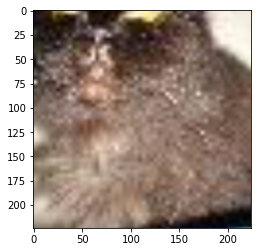

In [ ]:
idx = indexes[2]
printImage(train_ds[idx][0], train_ds[idx][1])

Label: ['tabby', 'tabby cat'] (30)


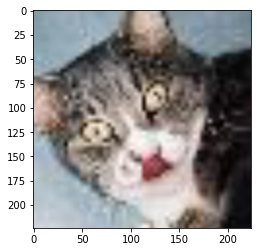

In [ ]:
indexes = [i for i in range(len(train_ds)) if train_ds[i][1] == C[0][0]]
idx = indexes[2]
printImage(train_ds[idx][0], train_ds[idx][1])

In [ ]:
vague_indexes = [i for i in range(len(train_ds)) if train_ds[i][1] == K]
print("Total number of vague training samples in \'{}\': {}".format(vague_classes[0], len(vague_indexes)))

Total number of vague training samples in 'n02121808': 375


Label: [['tabby', 'tabby cat'], ['Persian cat'], ['Egyptian cat']] (200)


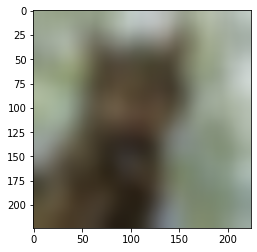

In [ ]:
vague_idx = vague_indexes[8]
printImage(train_ds[vague_idx][0], train_ds[vague_idx][1])

In [ ]:
indexes = [i for i in range(len(test_ds)) if test_ds[i][1] == C[0][1]]
print("Total number of non-vague test samples per subclass in \'{}\': {}".format(vague_classes[0], len(indexes)))

Total number of non-vague test samples per subclass in 'n02121808': 38


Label: ['Persian cat'] (31)


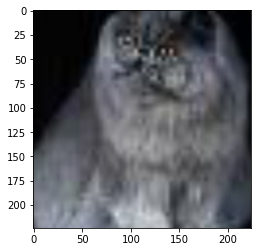

In [ ]:
idx = indexes[2]
printImage(test_ds[idx][0], test_ds[idx][1])

In [ ]:
vague_indexes = [i for i in range(len(test_ds)) if test_ds[i][1] == K]
print("Total number of vague training samples in \'{}\': {}".format(vague_classes[0], len(vague_indexes)))

Total number of vague training samples in 'n02121808': 36


Label: [['tabby', 'tabby cat'], ['Persian cat'], ['Egyptian cat']] (200)


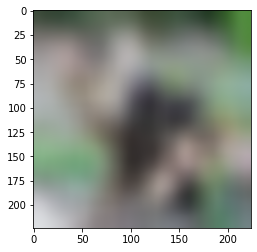

In [ ]:
vague_idx = vague_indexes[8]
printImage(test_ds[vague_idx][0], test_ds[vague_idx][1])

In [ ]:
start = time.time()
train_ds, valid_ds = make_valid_ds(train_ds, perc=0.1)
end = time.time()
print(f'Data splitted. training size: %d, validation size: %d, test size: %d'%(len(train_ds), len(valid_ds), len(test_ds)))
print(f'Splitting time: %s seconds.'%str(end-start))

Data splitted. training size: 90002, validation size: 9998, test size: 10000
Splitting time: 134.4446063041687 seconds.


In [ ]:
start = time.time()
preprocess_normalization = T.Compose([T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                  std=[0.229, 0.224, 0.225])])

train_ds = CustomDataset(subset=train_ds, transform=preprocess_normalization)
valid_ds = CustomDataset(subset=valid_ds, transform=preprocess_normalization)
test_ds = CustomDataset(subset=test_ds, transform=preprocess_normalization)
end = time.time()
print(f'Image preprocessed, total time: %s seconds'%str(end-start))

Image preprocessed, total time: 0.00040650367736816406 seconds


In [ ]:
batch_size = 64
print(f'using batch_size = %d'%batch_size)
n_batches = float(len(train_ds)/batch_size)

using batch_size = 64


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    device = torch.device('cuda:'+str(args.gpu)) if args.gpu in range(8) else torch.device('cpu')
    return device

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# device = torch.device('cuda:0')
device = get_default_device()
print(device)

cpu


In [ ]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=1, pin_memory=True)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=1, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
W = K
a = torch.div(torch.ones(K), K).to(device)

a_copy = a
for element in range(len(C)):
    sum_base_rates = torch.zeros(1).to(device)
    for l in C[element]:
        sum_base_rates = sum_base_rates + a[l]
    a_copy = torch.cat((a_copy, sum_base_rates.view(1)))

R = [[el] for el in range(K)]
for el in C:
    R.append(el)

# **HENN Training**

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
def get_partitions():
    remaining_indices = list(range(0, K))
    partitions = []
    for l in range(len(C)):
        partitions.append(C[l])
        for k in C[l]:
            remaining_indices.remove(k) 
    if len(remaining_indices):
        partitions.append(remaining_indices)
    return partitions

In [ ]:
partitions = get_partitions()
print('partition for GDD:')
print(partitions)

partition for GDD:
[[30, 31, 32], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]]


In [ ]:
def squaredLoss(alpha, one_hot_vectors):
    alpha_sum = torch.sum(alpha, dim=1)
    p_exp = torch.div(alpha, alpha_sum[:, None])

    num_classes = alpha.size(dim=1)
    num_samples = len(alpha)

    losses_term_1 = (one_hot_vectors - p_exp)**2
    losses_term_2 = (p_exp * (torch.ones(num_samples, num_classes).to(device) - p_exp) / ((alpha_sum + 1.0)[:, None]))                   
                        
    losses = torch.sum(losses_term_1 + losses_term_2, dim=1)

    return losses

def KL(alpha):
    num_classes = alpha.size(dim=1)
    beta = torch.ones(1, num_classes).to(device)
    S_beta = torch.sum(beta)
    S_alpha = torch.sum(alpha, dim=1) 
    lnB = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha),dim=1)
    lnB_uni = torch.sum(torch.lgamma(beta),dim=1) - torch.lgamma(S_beta)

    dg0 = torch.digamma(S_alpha)
    dg1 = torch.digamma(alpha)

    kl = torch.sum((alpha - beta)*(dg1-dg0[:, None]),dim=1) + lnB + lnB_uni

    return kl

def lossFunc(r, one_hot_labels, base_rate, annealing_coefficient):
    alpha = torch.add(r, torch.mul(W, base_rate))
    squared_loss = squaredLoss(alpha, one_hot_labels)
    # kl = KL(alpha)
    # return torch.mean(squared_loss + (annealing_coefficient * kl))
    # return squared_loss + (annealing_coefficient * kl), squared_loss, kl
    return torch.mean(squared_loss)

In [ ]:
class TinyImagenetEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        # EfficientNet
        self.network = EfficientNet.from_pretrained("efficientnet-b3", num_classes=kappa)
        self.output = nn.Softplus()
        
    def forward(self, x):
        logits = self.network(x)
        logits = self.output(logits)
        return logits

model = to_device(TinyImagenetEfficientNet(), device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


In [ ]:
def meanGDD(alpha, r):  
    num_partitions = len(partitions)

    beta = torch.zeros(len(alpha), num_partitions).to(device)
    alpha_sum = torch.zeros(len(alpha), len(C)).to(device)

    for l in range(len(C)):
        alpha_sum[:, l] = torch.sum(torch.index_select(alpha, 1, torch.tensor(partitions[l]).to(device)), dim = 1)
        beta[:, l] = alpha_sum[:, l] + r[:, K + l]

    if num_partitions > len(C):
        beta[:, len(C)] = torch.sum(torch.index_select(alpha, 1, torch.tensor(partitions[len(C)]).to(device)), dim = 1)

    p = torch.zeros(len(alpha), K).to(device)

    beta_sum = torch.sum(beta, dim=1)

    for l in range(len(C)):
        for k in partitions[l]:
            p[:, k] = (alpha[:, k] / beta_sum) * (beta[:, l] / alpha_sum[:, l])

    if num_partitions > len(C):
        for k in partitions[len(C)]:
            p[:, k] = alpha[:, k] / beta_sum

    return p

In [ ]:
def numAccurate(r, labels):
    alpha = torch.add(r[:,:K], torch.mul(W, a))

    # Get the predicted labels
    p_exp = meanGDD(alpha, r)
    predicted_labels = torch.argmax(p_exp, dim=1)

    total_correct = 0.0
    for i in range(len(labels)):
        predicted_set = set(R[torch.argmax(r[i])])

        if len(predicted_set) == 1:
            predicted_set = set(R[predicted_labels[i].item()])

        ground_truth_set = set(R[labels[i]])
        total_correct += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))

    return total_correct

In [ ]:
PATH_HENN = os.path.join(model_save_dir, "model_HENN.pt")

In [ ]:
PATH_HENN

'./models/model_HENN.pt'

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader, annealing_coefficient):
    model.eval()
    results = {
        'accuracy': 0.0,
        'mean_val_loss': 0.0
    }
    total_correct = 0.0
    total_samples = 0
    val_losses = []
    for batch in val_loader:
        images, labels = batch
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=kappa)
        r = model(images)
        loss = lossFunc(r, one_hot_labels, a_copy, annealing_coefficient)
        # batch_loss, _, _ = lossFunc(r, one_hot_labels, a_copy, annealing_coefficient)
        # loss = torch.mean(batch_loss)

        total_correct += numAccurate(r, labels)
        total_samples += len(labels)
        val_loss = loss.detach()
        val_losses.append(val_loss)
    results['mean_val_loss'] = torch.stack(val_losses).mean().item()
    results['accuracy'] = total_correct / total_samples
    return results

def fit(epochs, model, lr, train_loader, val_loader, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    global_step = 0
    annealing_step = 1000.0 * n_batches
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        squared_losses = []
        kls = []
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=kappa)
            r = model(images)
            annealing_coefficient = min(1.0, global_step/annealing_step)
            loss = lossFunc(r, one_hot_labels, a_copy, annealing_coefficient)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            # batch_loss, squared_loss, kl = lossFunc(r, one_hot_labels, a_copy, annealing_coefficient)
            # loss = torch.mean(batch_loss)
            # train_losses.append(loss)
            # squared_losses.append(torch.mean(squared_loss))
            # kls.append(torch.mean(kl))
            # loss.backward()
            # optimizer.step()
            global_step += 1
        mean_train_loss = torch.stack(train_losses).mean().item()
        # mean_squared_loss = torch.stack(squared_losses).mean().item()
        # mean_kl_loss = torch.stack(kls).mean().item()
        # Validation phase
        results = evaluate(model, val_loader, annealing_coefficient)
        print("Epoch [{}], Mean Training Loss: {:.4f}, Mean Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, mean_train_loss, results['mean_val_loss'], results['accuracy']))
        # print("Epoch [{}], Mean Training Loss: {:.4f}, Mean Squared Loss: {:.4f}, Annealing Coefficient: {}, Mean KL: {:.4f}, Mean Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"\
        # .format(epoch, mean_train_loss, mean_squared_loss, annealing_coefficient, mean_kl_loss, results['mean_val_loss'], results['accuracy']))
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), PATH_HENN)

In [ ]:
start = time.time()
for lr in [1e-3, 1e-4]:
    print("learning rate: {}".format(lr))

    if lr == 1e-3:
        num_epochs = 25
    else:
        num_epochs = 10

    fit(num_epochs, model, lr, train_dl, valid_dl, 0)

end = time.time()
torch.save(model.state_dict(), PATH_HENN)
print(f'Total training time for HENN: %s seconds.'%str(end-start))

learning rate: 0.001


# **HENN Testing**

In [ ]:
model = to_device(TinyImagenetEfficientNet(), device)
model.load_state_dict(torch.load(PATH_HENN))
model.eval()

Loaded pretrained weights for efficientnet-b3


TinyImagenetEfficientNet(
  (network): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
     

In [ ]:
def vague_belief_mass(b):
    b_v = torch.zeros(len(b), K).to(device)
    sum_beliefs = torch.zeros(len(b), K).to(device)

    for k in range(K):
        for l in range(len(C)):
            relative_base_rate = torch.zeros(1).to(device)
            intersection_set = set(R[k]).intersection(set(C[l]))
            if len(intersection_set) > 0:
                relative_base_rate = a_copy[R.index(list(intersection_set))] / a_copy[K + l]
            sum_beliefs[:, k] = sum_beliefs[:, k] + relative_base_rate * b[:, K + l]
        b_v[:, k] = sum_beliefs[:,k]
    
    return b_v

In [ ]:
def calculate_metrics(r, labels):
    correct_vague = 0.0
    correct_nonvague = 0.0
    vague_total = 0
    nonvague_total = 0
    
    alpha = torch.add(r[:,:K], torch.mul(W, a))

    # Get the predicted labels
    p_exp = meanGDD(alpha, r)
    predicted_labels = torch.argmax(p_exp, dim=1)

    # Calculate vaguenesses
    b = r / (torch.sum(r, dim=1) + W)[:, None]
    total_vaguenesses = torch.sum(b[:, K:], dim=1)
    b_v = vague_belief_mass(b)

    for i in range(len(labels)):
        k = labels[i].item()
        predicted_set = set(R[torch.argmax(r[i])])

        if len(predicted_set) == 1:
            predicted_set = set(R[predicted_labels[i].item()])

        ground_truth_set = set(R[k])

        if len(predicted_set) == 1:
            correct_nonvague += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))
            nonvague_total += 1
        else:
            correct_vague += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))
            vague_total += 1
      
    return [correct_nonvague, correct_vague, nonvague_total, vague_total]

In [ ]:
@torch.no_grad()
def evaluate_vague_nonvague(model, val_loader):
    model.eval()
    correct_vague = 0.0
    correct_nonvague = 0.0
    vague_total = 0
    nonvague_total = 0
    for batch in val_loader:
        images, labels = batch
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=kappa)
        r = model(images)                  
        results = calculate_metrics(r, labels)
        correct_nonvague += results[0]
        correct_vague += results[1]
        nonvague_total += results[2]
        vague_total += results[3]
    return [correct_vague, correct_nonvague, vague_total, nonvague_total]

In [ ]:
results = evaluate_vague_nonvague(model, test_dl)

In [ ]:
print("Average Jaccard Similarity Vague Classes: {}, Average Jaccard Similarity Nonvague Classes: {}".format(results[0] / results[2], results[1] / results[3]))

Average Jaccard Similarity Vague Classes: 0.16243654822335024, Average Jaccard Similarity Nonvague Classes: 0.14668978884015096


In [ ]:
print("Overall Accuracy: {}". format((results[0] + results[1])/(results[2] + results[3])))

Overall Accuracy: 0.147


In [ ]:
# def evaluate_set(model, data_loader):
#   vaguenesses = []
#   is_vague = []
#   for batch in data_loader:
#       images, labels = batch
#       r = model(images)
#       b = r / (torch.sum(r, dim=1) + W)[:, None]
#       total_vaguenesses = torch.sum(b[:, K:], dim=1)
#       is_vague += [y >= K for y in labels.detach().cpu().numpy().tolist()]
#       vaguenesses += total_vaguenesses.detach().cpu().numpy().tolist()
#   return is_vague, vaguenesses         

In [ ]:
# def draw_roc(model, data_loader):
#   is_vague, vaguenesses = evaluate_set(model, data_loader)
#   fpr, tpr, thresholds = metrics.roc_curve(is_vague, vaguenesses)
#   plt.plot(fpr, tpr)
#   plt.ylabel('True Positive Rate')
#   plt.xlabel('false Positive Rate')
#   plt.show()

In [ ]:
# draw_roc(model, test_dl)

RuntimeError: ignored

In [ ]:
# @torch.no_grad()
# def evaluate_per_class(model, val_loader):
#     model.eval()
#     total_class_totals = [0 for ele in range(kappa)]
#     class_accuracies = [0.0 for ele in range(kappa)]
#     average_class_vaguenesses = [0.0 for ele in range(kappa)]
#     average_class_vague_belief_masses = torch.zeros(K, kappa).to(device)
#     for batch in val_loader:
#         images, labels = batch
#         labels = labels.to(torch.int64)
#         one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=kappa)
#         r = model(images)                  
#         results = calculate_metrics(r, labels)
#         for k in range(kappa):
#             total_class_totals[k] += results[1][k]
#             average_class_vaguenesses[k] += results[2][k]
#             class_accuracies[k] += results[0][k]
#             average_class_vague_belief_masses[:, k] = average_class_vague_belief_masses[:, k] + results[3][:, k]
#     for k in range(kappa):
#         average_class_vaguenesses[k] = average_class_vaguenesses[k] / total_class_totals[k]
#         average_class_vague_belief_masses[:, k] = average_class_vague_belief_masses[:, k] / total_class_totals[k]
#         class_accuracies[k] = class_accuracies[k] / total_class_totals[k]
#     return [class_accuracies, average_class_vaguenesses, average_class_vague_belief_masses]

In [ ]:
# results = evaluate_per_class(model, test_dl)

In [ ]:
# print("Average Vagueness Vague Classes: {}, Average Vagueness Nonvague Classes: {}".format(torch.Tensor(results[1][K:]).mean().item(), torch.Tensor(results[1][:K]).mean().item()))
# print("Average Jaccard Similarity Vague Classes: {}, Average Accuracy Nonvague Classes: {}".format(torch.Tensor(results[0][K:]).mean().item(), torch.Tensor(results[0][:K]).mean().item()))

In [ ]:
# print("Overall Accuracy: {}". format(torch.Tensor(results[0]).mean().item()))

In [ ]:
# for k in range(kappa):
#   print("Average Vague Belief Mass of Class {} samples: {}".format(k, results[2][:, k]))

In [ ]:
# for l in range(len(C)):
#   for k in C[l]:
#     print("Class: {}, Accuracy: {:.4f}, Average Vagueness: {}".format(k, results[0][k], results[1][k]))

#   print("Class: {}, Average Jaccard Similarity: {:.4f}, Average Vagueness: {}\n".format(K + l, results[0][K + l], results[1][K + l]))

In [ ]:
# remaining_indices = list(range(0, K))
# for l in range(len(C)):
#   for k in C[l]:
#     remaining_indices.remove(k)

# for k in remaining_indices:
#   print("Class: {}, Accuracy: {:.4f}, Average Vagueness: {}".format(k, results[0][k], results[1][k]))

# **Baseline Data Preprocessing**

In [ ]:
def modify_vague_samples(dataset):
    for k in range(K, kappa):
        idx2 = [i for i in range(len(dataset)) if dataset[i][1] == k]
        idx1 = [i for i in range(len(dataset)) if dataset[i][1] != k]
        subset_1 = Subset(dataset, idx1)
        subset_2 = Subset(dataset, idx2)
        copies = CustomDataset(subset=subset_2, class_num=C[k - K][0])
        for l in range(1, len(C[k - K])):
            copies += CustomDataset(subset=subset_2, class_num=C[k - K][l])
        dataset = subset_1 + copies
    return dataset

In [ ]:
start = time.time()
train_ds = modify_vague_samples(train_ds)
end = time.time()
print(f'training samples modified: %d samples'%len(train_ds))
print(f'Time processing: %s seconds.'%str(end-start))

training samples modified: 90300 samples
Time processing: 303.27574920654297 seconds.


In [ ]:
# for l in C[0]:
#   indexes = [i for i in range(len(train_ds)) if train_ds[i][1] == l]
#   idx = indexes[600]
#   printImage(train_ds[idx][0].permute(1, 2, 0), train_ds[idx][1])

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)

# **EDL (1st Baseline)**

In [ ]:
class ENN(nn.Module):
    def __init__(self):
        super().__init__()

        # EfficientNet
        self.network = EfficientNet.from_pretrained("efficientnet-b3", num_classes=K)
        self.output = nn.Softplus()
        
    def forward(self, x):
        logits = self.network(x)
        logits = self.output(logits)
        return logits

model = to_device(ENN(), device)

Loaded pretrained weights for efficientnet-b3


In [ ]:
def get_dissonances(r):
    b = r / (torch.sum(r, dim=1) + W)[:, None]
    dissonances = torch.zeros(len(r), K).to(device)
    singletons = list(range(0, K))

    for k in range(K):
        selected_indices = torch.tensor(singletons[0:k] + singletons[k + 1:]).to(device)
        selected_b = torch.index_select(b, 1, selected_indices)
        bal_term2 = (torch.abs(selected_b - b[:, k][:, None]) / (selected_b + b[:, k][:, None]))
        bal_term2[torch.isnan(bal_term2)] = 0.0
        bal = 1.0 - bal_term2
        A = torch.sum(torch.mul(selected_b, bal), dim=1)
        B = torch.sum(selected_b, dim=1)
        dissonances[:, k] = torch.div(torch.mul(b[:, k], A), B)
    return dissonances

In [ ]:
def num_accurate_baseline1(r, labels, cutoff):
    alpha = torch.add(r, torch.mul(W, a))
    alpha_sum = torch.sum(alpha, dim=1)

    # Get the predicted labels
    p_exp = torch.div(alpha, alpha_sum[:, None])
    predicted_labels = torch.argmax(p_exp, dim=1)

    total_correct = 0.0
    for i in range(len(labels)):
        indices = (p_exp[i] >= cutoff).nonzero(as_tuple=True)[0]
        predicted_set = set(indices.tolist())

        if len(predicted_set) == 1:
            predicted_set = set(R[predicted_labels[i].item()])

        ground_truth_set = set(R[labels[i]])
        total_correct += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))

    return total_correct

In [ ]:
# model_save_dir = os.path.join(save_dir, 'models')
PATH_ENN = os.path.join(model_save_dir, "model_ENN.pt")

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader, cutoff):
    model.eval()
    total_correct = 0.0
    total_samples = 0
    val_losses = []
    for batch in val_loader:
        images, labels = batch
        r = model(images)
        total_correct += num_accurate_baseline1(r, labels, cutoff)
        total_samples += len(labels)
    accuracy = total_correct / total_samples
    return accuracy

def fit(epochs, model, lr, train_loader, val_loader, cutoff, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    global_step = 0
    annealing_step = 1000.0 * n_batches
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch
            one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=K)
            r = model(images)
            annealing_coefficient = min(1.0, global_step/annealing_step)
            loss = lossFunc(r, one_hot_labels, a, annealing_coefficient)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            global_step += 1
        mean_train_loss = torch.stack(train_losses).mean().item()
        # Validation phase
        accuracy = evaluate(model, val_loader, cutoff)
        print("Epoch [{}], Mean Training Loss per Batch: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, mean_train_loss, accuracy))
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), PATH_ENN)

In [ ]:
start = time.time()
for lr in [1e-3, 1e-4]:
    print("learning rate: {}".format(lr))

    if lr == 1e-3:
        num_epochs = 25
    else:
        num_epochs = 10
    fit(num_epochs, model, lr, train_dl, valid_dl, 0.2, 0)

end = time.time()
torch.save(model.state_dict(), PATH_ENN)
print(f'Total training time for ENN: %s seconds.'%str(end-start))

learning rate: 0.001


RuntimeError: ignored

In [ ]:
model = to_device(ENN(), device)
model.load_state_dict(torch.load(PATH_ENN))
model.eval()

Loaded pretrained weights for efficientnet-b3


FileNotFoundError: ignored

In [ ]:
cutoff = 0.0
end_cutoff = 1
interval = 0.05
while cutoff <= end_cutoff:
    accuracy = evaluate(model, valid_dl, cutoff)
    print("For cutoff = {}, Validation Accuracy: {:.4f}".format(cutoff, accuracy))    
    cutoff += interval

In [ ]:
final_cutoff = 0.225

In [ ]:
def calculate_metrics_baseline1(r, labels, cutoff):
    correct_vague = 0.0
    correct_nonvague = 0.0
    vague_total = 0
    nonvague_total = 0

    alpha = torch.add(r, torch.mul(W, a))
    alpha_sum = torch.sum(alpha, dim=1)

    # Get the predicted labels
    p_exp = torch.div(alpha, alpha_sum[:, None])
    predicted_labels = torch.argmax(p_exp, dim=1)

    for i in range(len(labels)):
        k = labels[i].item()

        indices = (p_exp[i] >= cutoff).nonzero(as_tuple=True)[0]
        predicted_set = set(indices.tolist())

        if len(predicted_set) == 1:
            predicted_set = set(R[predicted_labels[i].item()])

        ground_truth_set = set(R[k])

        if len(predicted_set) == 1:
            correct_nonvague += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))
            nonvague_total += 1
        else:
            correct_vague += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))
            vague_total += 1

    return [correct_nonvague, correct_vague, nonvague_total, vague_total]

In [ ]:
@torch.no_grad()
def evaluate_per_class_baseline1(model, val_loader, cutoff):
    model.eval()
    correct_vague = 0.0
    correct_nonvague = 0.0
    vague_total = 0
    nonvague_total = 0
    for batch in val_loader:
        images, labels = batch
        r = model(images)                  
        results = calculate_metrics_baseline1(r, labels, cutoff)
        correct_nonvague += results[0]
        correct_vague += results[1]
        nonvague_total += results[2]
        vague_total += results[3]
    return [correct_vague, correct_nonvague, vague_total, nonvague_total]

In [ ]:
results = evaluate_per_class_baseline1(model, test_dl, final_cutoff)

In [ ]:
print("Average Jaccard Similarity Vague Classes: {}, Average Jaccard Similarity Nonvague Classes: {}".format(results[0] / results[2], results[1] / results[3]))

In [ ]:
print("Overall Accuracy: {}". format((results[0] + results[1])/(results[2] + results[3])))

# **Deterministic Neural Network (2nd Baseline)**

In [ ]:
class Deterministic_NN(nn.Module):
    def __init__(self):
        super().__init__()

        # EfficientNet
        self.network = EfficientNet.from_pretrained("efficientnet-b3", num_classes=K)
        
    def forward(self, x):
        return self.network(x)

model = to_device(Deterministic_NN(), device)

In [ ]:
def num_accurate_baseline2(p, labels, cutoff):
    p = F.softmax(p,dim=1)
    predicted_labels = torch.argmax(p, dim=1)

    total_correct = 0.0
    for i in range(len(labels)):
        indices = (p[i] >= cutoff).nonzero(as_tuple=True)[0]
        predicted_set = set(indices.tolist())

        if len(predicted_set) == 1:
            predicted_set = set(R[predicted_labels[i].item()])

        ground_truth_set = set(R[labels[i]])
        total_correct += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))

    return total_correct

In [ ]:
PATH_DetNN = os.path.join(model_save_dir, "model_DetNN.pt")

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader, cutoff):
      model.eval()
      total_correct = 0.0
      total_samples = 0
      val_losses = []
      for batch in val_loader:
          images, labels = batch
          r = model( images)
          total_correct += num_accurate_baseline2(r, labels, cutoff)
          total_samples += len(labels)
      accuracy = total_correct / total_samples
      return accuracy

def fit(epochs, model, lr, train_loader, val_loader, cutoff, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch
            p = model(images)
            loss = F.cross_entropy(p, labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
        mean_train_loss = torch.stack(train_losses).mean().item()
        # Validation phase
        results = evaluate(model, val_loader, cutoff)
        print("Epoch [{}], Mean Training Loss per Batch: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, mean_train_loss, results))
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), PATH_DetNN)

In [ ]:
start = time.time()
for lr in [1e-3, 1e-4]:
  print("learning rate: {}".format(lr))

  if lr == 1e-3:
      num_epochs = 25
  else:
      num_epochs = 10

  fit(num_epochs, model, lr, train_dl, valid_dl, 0.2, 0)

end = time.time()
torch.save(model.state_dict(), PATH_DetNN)
print(f'Total training time for Deterministic NN: %s seconds.'%str(end-start))

In [ ]:
model = to_device(Deterministic_NN(), device)
model.load_state_dict(torch.load(PATH_DetNN))
model.eval()

In [ ]:
cutoff = 0.0
end_cutoff = 1
interval = 0.05
while cutoff <= end_cutoff:
    accuracy = evaluate(model, valid_dl, cutoff)
    print("For cutoff = {}, Validation Accuracy: {:.4f}".format(cutoff, accuracy))    
    cutoff += interval

In [ ]:
final_cutoff = 0.2

In [ ]:
def calculate_metrics_baseline2(p, labels, cutoff):
    correct_vague = 0.0
    correct_nonvague = 0.0
    vague_total = 0
    nonvague_total = 0

    p = F.softmax(p,dim=1)
    predicted_labels = torch.argmax(p, dim=1)

    for i in range(len(labels)):
        k = labels[i].item()

        indices = (p[i] >= cutoff).nonzero(as_tuple=True)[0]
        predicted_set = set(indices.tolist())

        if len(predicted_set) == 1:
            predicted_set = set(R[predicted_labels[i].item()])

        ground_truth_set = set(R[k])

        if len(predicted_set) == 1:
            correct_nonvague += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))
            nonvague_total += 1
        else:
            correct_vague += float(len(predicted_set.intersection(ground_truth_set))) / len(predicted_set.union(ground_truth_set))
            vague_total += 1

    return [correct_nonvague, correct_vague, nonvague_total, vague_total]

In [ ]:
@torch.no_grad()
def evaluate_per_class_baseline2(model, val_loader, cutoff):
    model.eval()
    correct_vague = 0.0
    correct_nonvague = 0.0
    vague_total = 0
    nonvague_total = 0
    for batch in val_loader:
        images, labels = batch
        r = model(images)                  
        results = calculate_metrics_baseline2(r, labels, cutoff)
        correct_nonvague += results[0]
        correct_vague += results[1]
        nonvague_total += results[2]
        vague_total += results[3]
    return [correct_vague, correct_nonvague, vague_total, nonvague_total]

In [ ]:
results = evaluate_per_class_baseline2(model, test_dl, final_cutoff)

In [ ]:
print("Average Jaccard Similarity Vague Classes: {}, Average Jaccard Similarity Nonvague Classes: {}".format(results[0] / results[2], results[1] / results[3]))

In [ ]:
print("Overall Accuracy: {}". format((results[0] + results[1])/(results[2] + results[3])))